In [1]:
import pandas as pd
import jax.numpy as jnp
import evofr as ef
import numpy as np

In [2]:
# Getting data
raw_cases = pd.read_csv("../data/monkeypox-cases-counts.tsv", sep="\t")
raw_cases.location.value_counts()

World             270
United Kingdom    265
Portugal          255
Spain             254
Belgium           253
France            253
Italy             253
Germany           252
Switzerland       251
Austria           249
Slovenia          248
Canada            238
United States     238
Colombia          216
Peru              213
Slovakia          204
Name: location, dtype: int64

In [3]:
region = {'Canada':'North America',
          'United States':'North America',
         'Finland':'Northern Europe',
           'Austria': 'Western Europe',
        'Germany':'Western Europe', 
        'Switzerland':'Western Europe',
         'United Kingdom':'Western Europe',
        'France':'Western Europe',
        'Belgium':'Western Europe',
        'Netherlands':'Western Europe',
        'Slovakia':'Central Europe',
        'Slovenia':'Central Europe',
        'Italy':'Southern Europe',
        'Portugal':'Southern Europe',
        'Spain':'Southern Europe',
         'Colombia':'South America',
          
        'Peru':'South America'}

In [4]:
raw_cases["region"] = np.nan
raw_cases.region = raw_cases.location.map(region)
raw_cases = raw_cases.dropna()


In [5]:
raw_cases = raw_cases.dropna()
raw_cases

,location,date,cases,region
0,Austria,2022-05-23,1.0,Western Europe
1,Austria,2022-05-24,0.0,Western Europe
2,Austria,2022-05-25,0.0,Western Europe
3,Austria,2022-05-26,0.0,Western Europe
4,Austria,2022-05-27,0.0,Western Europe
...,...,...,...,...
3637,United States,2023-01-22,0.0,North America
3638,United States,2023-01-23,0.0,North America
3639,United States,2023-01-24,6.0,North America
3640,United States,2023-01-25,5.0,North America


In [6]:
locations_to_run = raw_cases["region"].unique()
#locations_to_run = ["World", "United States"] # Comment out this line to run all locations

In [7]:
# Make case_data dictionary
case_data = dict()
for name in locations_to_run:
    case_data[name] = ef.CaseCounts(raw_cases=raw_cases[raw_cases.region == name].copy())

In [25]:
# Defining model
seed_L = 14
forecast_L = 0

# Get delays
gen = ef.discretise_gamma(mn=12.6, std=5.66)
delays = ef.pad_delays([ef.discretise_lognorm(mn=4.1, std=1.0)])
inf_period = ef.discretise_gamma(mn=4.5, std=3.2)
basis_fn = ef.Spline(order=4, k=5)

renewal_model = ef.SingleRenewalModel(gen, delays, seed_L, forecast_L,
                       inf_period = inf_period,
                       CLik = ef.ZINegBinomCases(0.01),
                       basis_fn = basis_fn)

In [26]:
# Fitting model
multiposterior = ef.MultiPosterior()
for name, data in case_data.items():
    print(name)
    #init_strat, posterior_map = ef.init_to_MAP(renewal_model, data, iters=10_000)
    #inference_method = ef.InferNUTS(num_warmup=500, num_samples=200, init_strategy=init_strat)
    #inference_method = ef.InferNUTS(num_warmup=500, num_samples=200)
    inference_method = ef.InferFullRank(iters=50_000, lr=4e-3, num_samples=500)
    posterior = inference_method.fit(renewal_model, data, name=name)
    multiposterior.add_posterior(posterior)

Western Europe
North America
South America
Southern Europe
Central Europe


In [27]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 16}

matplotlib.rc('font', **font)

In [28]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]

v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#808080"]

In [29]:
from evofr.plotting import *

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [30]:
def plot_site(ax, site, samples, ps, alphas, color):
    med, V = get_quantiles(samples, ps, site)
    t = jnp.arange(0, V[-1].shape[-1], 1)

    # Make figure
    for i in range(len(ps)):
        ax.fill_between(
            t, V[i][0, :], V[i][1, :], color=color, alpha=alphas[i]
        )
    ax.plot(t, med, color=color)

In [31]:
def plot_posterior_Reff_r(posterior, color="grey"):
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1)

    # Plot Reff
    ax = fig.add_subplot(gs[0,0])
    plot_site(ax, "R", posterior.samples, ps, alphas, color)
    ax.set_ylabel("Effective Reproduction number") # Making ylabel

    # Plot little R
    ax = fig.add_subplot(gs[1,0], sharex=ax)
    plot_site(ax, "r", posterior.samples, ps, alphas, color)
    ax.set_ylabel("Epidemic growth rate (per day)") # Making ylabel

    # Add dates
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates

    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return None

In [32]:
def plot_posterior_Ismooth_cases(posterior, color="grey"):
    fig = plt.figure(figsize=(14, 7))
    gs = fig.add_gridspec(nrows=1, ncols=1)

    # Plot smoothed incidence
    ax = fig.add_subplot(gs[0,0])
    plot_site(ax, "I_smooth", posterior.samples, ps, alphas, color)

    plot_cases(ax, posterior.data)
    ax.set_ylabel("Cases") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates
    return None

In [33]:
def plot_cute_posterior(posterior, main_color="#FF00FF", title=""):
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[0.7, 0.3])

    # Plot smoothed incidence and cases
    ax = fig.add_subplot(gs[0,0])
    simple_axis(ax)
    plot_site(ax, "I_smooth", posterior.samples, ps, alphas, main_color)
    plot_cases(ax, posterior.data)
    ax.set_ylabel("Cases") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates
    ax.set_title(title)
    
    # Plot Reff
    ax = fig.add_subplot(gs[1,0])
    simple_axis(ax)
    plot_site(ax, "R", posterior.samples, ps, alphas, main_color)
    ax.set_ylabel(r"$R_{t}$") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=14) # Adding dates
    ax.axhline(y=1.0, color="k", linestyle="--")
    return None

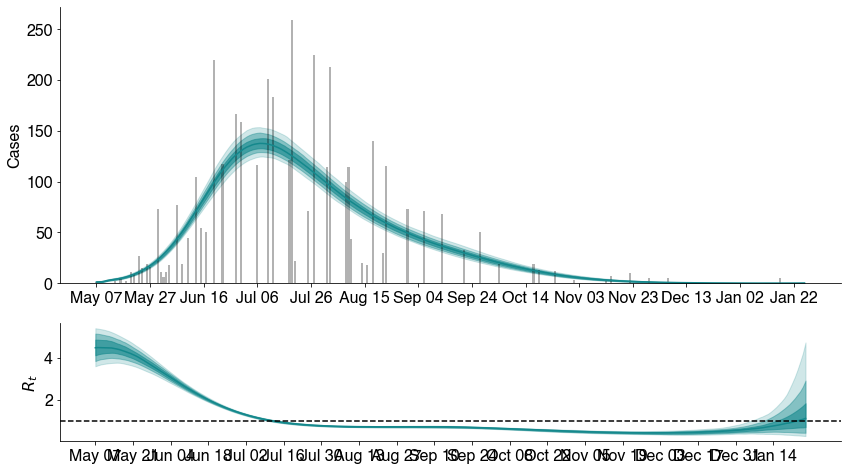

In [34]:
posterior = multiposterior["Western Europe"]
plot_cute_posterior(posterior, main_color="#14888c")

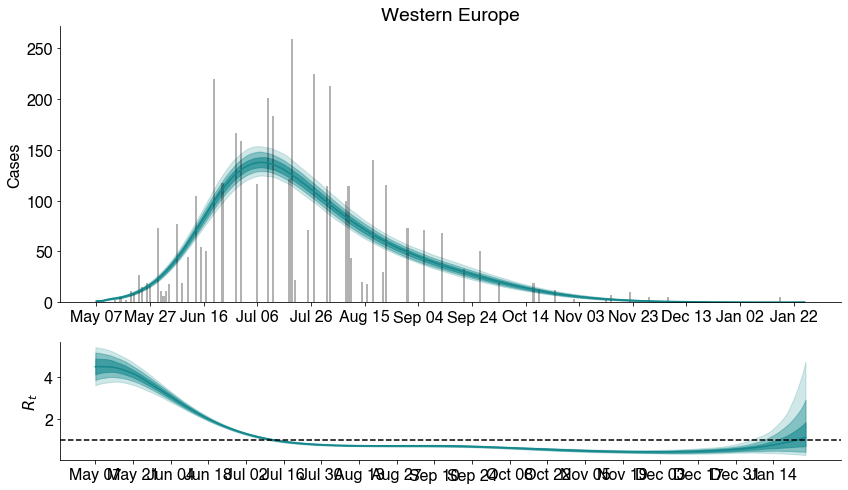

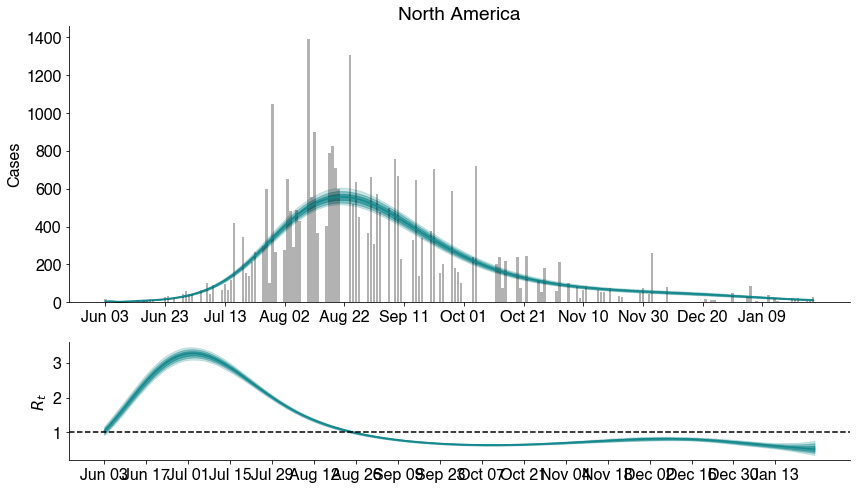

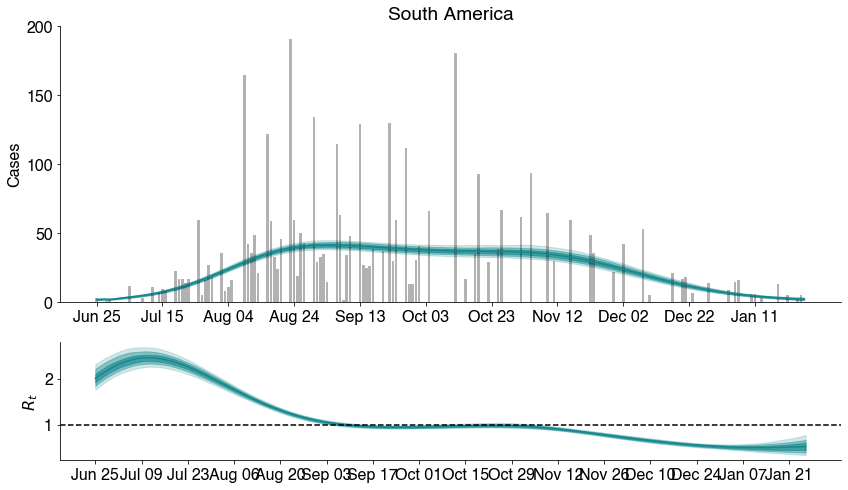

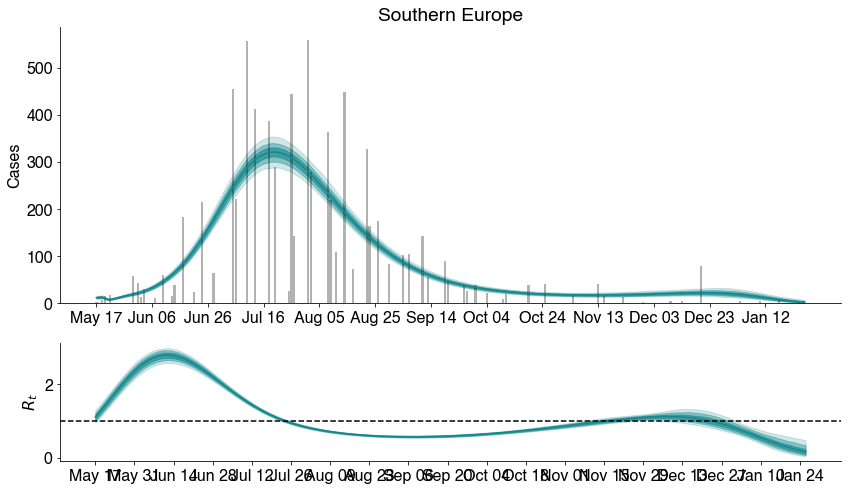

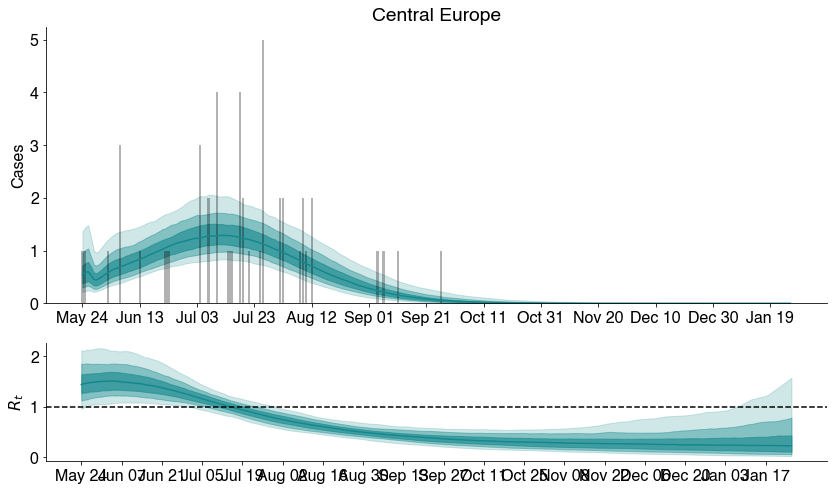

In [35]:
for name, post in multiposterior.locator.items():
    plot_cute_posterior(p, main_color="#14888c", title=name)

In [36]:
def get_site(
    samples, data, ps, name, site, forecast=False
):

    dates = data.dates

    # Unpack posterior
    site_name = site + "_forecast" if forecast else site
    site = samples[site_name]
    T = len(dates)

    if forecast:
        dates = forecast_dates(dates, T)

    # Compute medians and hdis for ps
    site_median = jnp.median(site, axis=0)

    site_hdis = [
        jnp.quantile(site, q=jnp.array([0.5 * (1 - p), 0.5 * (1 + p)]), axis=0)
        for p in ps
    ]

    site_dict = dict()
    site_dict["date"] = list(dates)
    site_dict["region"] = [name] * T
    site_dict[f"median_{site_name}"] = list(site_median)[-T:]
    for i, p in enumerate(ps):
        site_dict[f"{site_name}_upper_{round(ps[i] * 100)}"] = list(site_hdis[i][1, -T:])
        site_dict[f"{site_name}_lower_{round(ps[i] * 100)}"] = list(site_hdis[i][0, -T:])        
    return site_dict

In [37]:
def site_posteriors_to_dataframe(mp, site, ps):
    dfs = []
    for name, post in multiposterior.locator.items():
        site_dict_name = get_site(post.samples, post.data, ps, name, site, forecast=False)
        print(name)
        dfs.append(
            pd.DataFrame(site_dict_name)
        )
    return pd.concat(dfs)

In [38]:
Rt_estimates = site_posteriors_to_dataframe(multiposterior, "R", [0.95])

Western Europe
North America
South America
Southern Europe
Central Europe


In [39]:
incidence_estimates = site_posteriors_to_dataframe(multiposterior, "I_smooth", [0.95])

Western Europe
North America
South America
Southern Europe
Central Europe


In [40]:
prev_estimates = site_posteriors_to_dataframe(multiposterior, "prev", [0.95])

Western Europe
North America
South America
Southern Europe
Central Europe


In [41]:
Rt_estimates.to_csv("case-rt-estimates_region.tsv", index=False, sep="\t")
incidence_estimates.to_csv("case-incidence-estimates_region.tsv", index=False, sep="\t")
prev_estimates.to_csv("case-prevalence-estimates_region.tsv", index=False, sep="\t")